In [68]:
import math
import os
import pandas as pd
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import chromosomeDefinition as cd
import analyseVCF as aVCF
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
%pprint

Pretty printing has been turned ON


In [69]:
CNV_COLUMNS = ['chrom','posStart','posEnd','copyNum','gainOrLoss','BAF','score','germlineOrSomatic','oneOrZero']

In [70]:
# LOAD BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
BED_FILE_NAME = "cosmicCurated.bed" 
BED_FILE_NAME = "cosmicCancerCensus.bed"
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"
#BED_FILE_NAME = "CPCT_Slicing.bed"
USE_BED = True
LOAD_FULL_FILE = True

### FUNCTIONS

In [71]:
def findFiles(path,suffix):
    files=[]
    for x in os.listdir(path):
        if x[-len(suffix):] == suffix:
            files.append(x)
    return files

In [72]:
def loadCNVforPatient(cnvFile,patientName):
    dfCNV = pd.read_table(cnvFile, names = CNV_COLUMNS )
    #print dfCNV
    #add regions with default copy number
    last = dfCNV.iloc[0]
    for i in range(1, dfCNV.shape[0]-1):
        #print last.chrom,last.posStart,last.posEnd
        if last['posEnd']<>dfCNV.iloc[i]['posStart']:
            if last['chrom']==dfCNV.iloc[i]['chrom']:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], dfCNV.iloc[i]['posStart']-1,2,'none','-','-','-','-']
            else:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], cd.chromosomeLength[last['chrom']],2,'none','-','-','-','-']
                if dfCNV.iloc[i]['posStart']<>0:
                    dfCNV.loc[len(dfCNV)] = [dfCNV.iloc[i]['chrom'],0, dfCNV.iloc[i]['posStart'],2,'none','-','-','-','-']
        last = dfCNV.iloc[i]
    #fix first record
    if dfCNV.iloc[0]['posStart']<>0:
        dfCNV.loc[len(dfCNV)] = ['1',0, dfCNV.iloc[0]['posStart'],2,'none','-','-','-','-']
    #Additional Fields
    dfCNV['chromPos']= dfCNV['chrom'].apply(lambda x: cd.intChrom(x)) + dfCNV['posStart'] / dfCNV['chrom'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfCNV['chrom'] = dfCNV['chrom'].apply(lambda x: cd.intChrom(x))
    dfCNV['cappedCopyNum'] = dfCNV['copyNum'].clip(upper=5)
    dfCNV = dfCNV.sort_values(["chrom","posStart","posEnd"]).reset_index()
    dfCNV['regionLength'] = (dfCNV['posEnd']-dfCNV['posStart'])
    dfCNV['patientName']=patientName
    return dfCNV

In [79]:
def nonZeroCountBetween(chrom,minPos,maxPos):
    temp = dfTumorRatio[(dfTumorRatio.Chromosome==chrom)&(dfTumorRatio.Start>minPos)&\
                       (dfTumorRatio.Start<maxPos)&(dfTumorRatio.Ratio_x<>-1)]
    return temp['Start'].count(),temp['Ratio_x'].mean(),temp['Ratio_y'].mean(),temp['MedianRatio_x'].mean(),temp['MedianRatio_y'].mean()

In [80]:
def fitBAFPeak(mBAF):
    return min(mBAFPeaks, key=lambda x:abs(x-mBAF))

def fitCNVPeak(ratio):
    return min(cnvPeaks, key=lambda x:abs(x-ratio))

In [402]:
def patientIDFromFilename(filename):
    patientIDStart = filename.find("DRUP0")
    return filename[patientIDStart:patientIDStart+12]

In [84]:
def loadVCF(path,filename,sampleNames,patientID):
    df = pd.DataFrame()
    if USE_BED:
        bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True,True,bed,LOAD_FULL_FILE)])
    else:
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True)])

In [85]:
def calculateMBAFBetween(chrom,minPos,maxPos):
    dftemp = dfBAF[(dfBAF.Chromosome==chrom)&(dfBAF.Position>minPos)&(dfBAF.Position<maxPos)]
    return dftemp['mBAF'].median(),dftemp['mBAF'].count()

In [86]:
def createBAF(dfGermline):
    dfBAF = dfGermline[(dfGermline['variantType']=="SNP")&(dfGermline['normalSGT']=="0/1")&(dfGermline['normalAF']>0.4) \
                   &(dfGermline['normalAF']<0.65)&(dfGermline['normalDP']>30)&\
                   (dfGermline['normalDP']<40)][['chrom','pos','tumorAF']]
    dfBAF.columns = ['Chromosome', 'Position','BAF']
    dfBAF['Position'] = pd.to_numeric(dfBAF['Position'])
    dfBAF['mBAF']= 0.5+abs(dfBAF['BAF']-0.5)
    dfBAF['chromPos']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x)) + dfBAF['Position'] / dfBAF['Chromosome'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfBAF['Chromosome']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x))
    return dfBAF

In [88]:
def AFByPosPlot(pos,AF,startChartPos,endChartPos):
    plt.figure(figsize=[18,3])
    plt.scatter(pos, AF)
    plt.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.axis([startChartPos, endChartPos,0, 1.0])
    plt.show()

In [148]:
def findPeaks(log_dens,X_range):
    peaks = []
    troughs = []
    dens=np.exp(log_dens)
    diff = [dens[x] - dens[x-1] for x in range(1,len(dens))]
    for i in range (len(diff)-1):
        if diff[i+1] < 0 and diff[i] > 0:
            peaks.append(float(i+1)/len(dens)*X_range)
        if diff[i+1] > 0 and diff[i] < 0:
            troughs.append(float(i+1)/len(dens)*X_range)
    return peaks#, troughs

In [308]:
def fitCNVPurity(tumorCNV,CNVRatioWeightFactor,minPurity,maxPurity,
                 stepsPurity,minCNVNormFactor,maxCNVNormFactor,stepsCNVNormFactor,printDetail=False):
    fitResults = []
    for purity in np.linspace(minPurity,maxPurity,stepsPurity):
        for CNVNormalisationFactor in np.linspace(minCNVNormFactor,maxCNVNormFactor,stepsCNVNormFactor):
            modelDeviation = 0
            for i in range(0, len(tumorCNV)):
                if tumorCNV[i][1] > 0 and  tumorCNV[i][2] >= 0 : #
                    # Should also correct for mBAF < 0.5
                    minDeviation,bestFittedBAF,fittedPloidy = 1e9,0,0   #reset variables
                    for ploidy in range(1,10):
                        modelCNVratio = CNVNormalisationFactor + (ploidy-2)*purity*CNVNormalisationFactor/2
                        CNVDeviation = ploidy/2.0*CNVRatioWeightFactor*abs(modelCNVratio-tumorCNV[i][3])  #OR TUMOR RATIO???
                        for BAF in range(int(math.ceil(ploidy/2.0)),ploidy+1):
                            if float(BAF)/ploidy >0.49 and float(BAF)/ploidy <0.51:
                                modelBAF = 0.533
                            else:
                                modelBAF = (1+purity*(BAF-1))/(2+purity*(ploidy-2))
                            if minDeviation > (abs(modelBAF-tumorCNV[i][0]) + CNVDeviation):
                                minDeviation = (abs(modelBAF-tumorCNV[i][0]) + CNVDeviation)
                                bestFittedBAF = modelBAF
                                fittedPloidy = ploidy
                    modelDeviation = modelDeviation + tumorCNV[i][1]*minDeviation
                if printDetail and tumorCNV[i][1] >= 50:
                    print purity,CNVNormalisationFactor,bestFittedBAF,fittedPloidy,tumorCNV[i][1]*minDeviation,tumorCNV[i][4],tumorCNV[i][5],tumorCNV[i][6]
            fitResults.append([purity,CNVNormalisationFactor, modelDeviation])
    dfFitOutput = pd.DataFrame(sorted(fitResults, key=lambda x: x[2]))
    dfFitOutput.columns = ["purity","NormFactor",'score']
    return dfFitOutput

### ANALYSIS

In [404]:
PATH="/Users/peterpriestley/hmf/analyses/DRUP01010014/"
tumorCNVFileName=findFiles(PATH,"gz_CNVs")[0]
normalCNVFileName=findFiles(PATH,"normal_CNVs")[0]
tumorRatioFileName=findFiles(PATH,"gz_ratio.txt")[0]
normalRatioFileName=findFiles(PATH,"gz_normal_ratio.txt")[0]
germlineVCFFilename = findFiles(PATH,"SLICED.vcf")[0]
patientID = patientIDFromFilename(germlineVCFFilename)
print "germline =",germlineVCFFilename
print "patient =",patientID
print "CNV =",tumorCNVFileName

germline = 170324_HMFregDRUP_FR12246226_FR13274435_DRUP01010014.annotatedSLICED.vcf
patient = DRUP01010014
CNV = DRUP01010014T_dedup.realigned.pileup.gz_CNVs


In [405]:
dfGermline = loadVCF(PATH,germlineVCFFilename,{patientID+'R':'normal',patientID+'T':'tumor'},patientID)

reading vcf file: 170324_HMFregDRUP_FR12246226_FR13274435_DRUP01010014.annotatedSLICED.vcf
reading VCF File line: 1
reading VCF File line: 200001
Number variants loaded: 345644


In [406]:
dfBAF = createBAF(dfGermline)

In [407]:
dfTumorCNV = loadCNVforPatient(PATH+tumorCNVFileName,patientName)
dfNormalCNV = loadCNVforPatient(PATH+normalCNVFileName,patientName)

In [408]:
dfTumorCNV['mBAF'], dfTumorCNV['mBAFCount'] = \
    np.vectorize(calculateMBAFBetween)(dfTumorCNV['chrom'], dfTumorCNV['posStart'],dfTumorCNV['posEnd'])

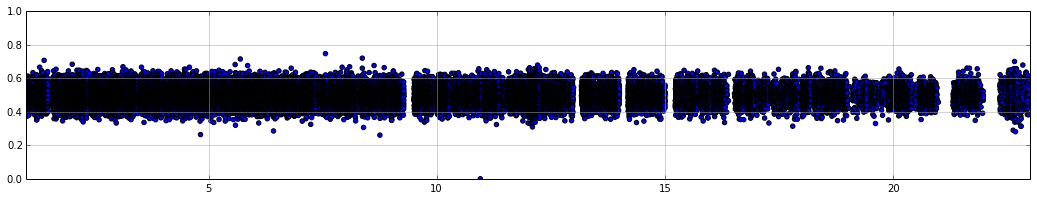

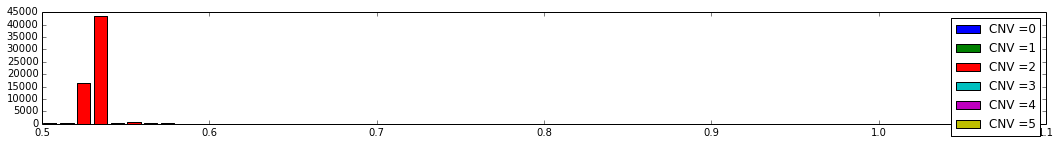

In [409]:
c, fractionMin, fractionMax = 1,0,22
dfSom = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
AFByPosPlot(dfSom.chromPos, dfSom.BAF,c+fractionMin, c+fractionMax)

dftemp = dfTumorCNV[(dfTumorCNV.mBAF>=0.0)&(dfTumorCNV.mBAF<=1.0)&(dfTumorCNV.mBAFCount>20)&(dfTumorCNV.chromPos<=c+fractionMax)&(dfTumorCNV.chromPos>=c+fractionMin)]
plt.figure(figsize=[18,2])
for CNV in range(0,6):
    plt.hist(dftemp[(dftemp.copyNum==CNV)]['mBAF'].values,cumulative=False, normed=False, bins=50,range=(0.5,1.0),weights=dftemp[(dftemp.copyNum==CNV)]['mBAFCount'].values,stacked = True,rwidth=0.8,label='CNV ='+str(CNV))
    plt.legend()
plt.show()

### Ratio calculations

In [ ]:
dfTumorRatio = pd.read_table(PATH + tumorRatioFileName, header=0)
dfNormalRatio = pd.read_table(PATH + normalRatioFileName, header=0)
dfTumorRatio.set_index(['Chromosome','Start'],inplace=True)
dfNormalRatio.set_index(['Chromosome','Start'],inplace=True)
dfTumorRatio = pd.merge(dfTumorRatio,dfNormalRatio,how='inner', left_index=True,right_index=True)
dfTumorRatio['ratio']= pd.to_numeric(dfTumorRatio['Ratio_x'],errors=coerce) /pd.to_numeric(dfTumorRatio['Ratio_y'],errors=coerce)
dfTumorRatio = dfTumorRatio.reset_index()
dfTumorRatio['chromPos'] = dfTumorRatio['Chromosome'].apply(lambda x: cd.intChrom(str(x))) + \
    dfTumorRatio['Start']/dfTumorRatio['Chromosome'].map(lambda x: cd.chromosomeLength[str(x)])
dfTumorRatio['Chromosome'] = dfTumorRatio['Chromosome'].apply(lambda x: cd.intChrom(str(x)))

In [ ]:
dfTumorCNV['nonZeroCount'],dfTumorCNV['tumorRatio'],dfTumorCNV['normalRatio'] \
    ,dfTumorCNV['tumorMedianRatio'],dfTumorCNV['normalMedianRatio'] = \
    np.vectorize(nonZeroCountBetween)(dfTumorCNV['chrom'], dfTumorCNV['posStart'],dfTumorCNV['posEnd'])
dfTumorCNV['ratioOfRatio']=dfTumorCNV.tumorRatio/dfTumorCNV.normalRatio

### PEAK FINDING

In [ ]:
#X = dfTumorCNV[dfTumorCNV.nonZeroCount>10].ratioOfRatio.sort_values()[:, np.newaxis]
X_range = 5
X_plot = np.linspace(0,X_range,1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(dfTumorCNV[(dfTumorCNV.nonZeroCount>10)].tumorRatio.sort_values()[:, np.newaxis])
log_dens = kde.score_samples(X_plot)
cnvPeaks = findPeaks(log_dens,X_range)
X_range = 1
X_plot = np.linspace(0,X_range,1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.005).fit(dfTumorCNV[dfTumorCNV.mBAFCount>10].mBAF.sort_values()[:, np.newaxis])
log_dens = kde.score_samples(X_plot)
mBAFPeaks = findPeaks(log_dens,X_range)

In [ ]:
dfTumorCNV['fittedBAFPeak'] = np.vectorize(fitBAFPeak)(dfTumorCNV['mBAF'])
dfTumorCNV['fittedCNVPeak'] = np.vectorize(fitCNVPeak)(dfTumorCNV['ratioOfRatio'])
pd.pivot_table(dfTumorCNV[dfTumorCNV.chrom<=22], values='mBAFCount', index=['fittedBAFPeak'], columns=['fittedCNVPeak'], aggfunc='sum',margins=True).fillna("")

### Fitting

In [ ]:
CNVFit = fitCNVPurity(dfTumorCNV[dfTumorCNV.chrom<=22]\
            [['mBAF','mBAFCount','tumorRatio','ratioOfRatio','chrom','posStart','regionLength']]\
                      .values.tolist(),0.2,0.12,1.0,23,0.5,1.2,15)
CNVFit.head()

In [ ]:
CNVFit = fitCNVPurity(dfTumorCNV[['mBAF','mBAFCount','tumorRatio','ratioOfRatio',\
                'chrom','posStart','regionLength']].values.tolist(),0.2,0.11,0.31,21,0.72,0.93,8,False)
CNVFit.head()